## **Statistical Arbitrage - Pairs Trading**

In [57]:
# -*- coding: utf-8 -*-
"""
Created on Dec 21 12:13:00 2022

@author: Bradley

Sample code for statistical arbitrage
"""

'\nCreated on Dec 21 12:13:00 2022\n\n@author: Bradley\n\nSample code for statistical arbitrage\n'

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
from functools import partial
import os

import warnings
warnings.filterwarnings('ignore') 

from IPython.display import display
pd.set_option('expand_frame_repr', True) 
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180) #
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


In [112]:
from utils.ArbUtils import *

#### **Exploratory Data Analysis**

In [113]:
market_data = pd.read_csv("./data/price_stock.csv", index_col=[0])
market_data.index.name = 'time'
market_data.columns = [market_data.columns.str[-2:], market_data.columns.str[:-3]]
market_data

AA                                    BB                                    CC            ...       MM                 NN                               \
                 BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume  ... AskPrice AskVolume BidPrice BidVolume AskPrice AskVolume   
time                                                                                                             ...                                                            
01/01/2018 00:05    80.00       135    80.25       135   100.55       105   100.85       105    97.85       112  ...    95.20       140   137.20       122   137.60       122   
01/01/2018 00:10    79.95       124    80.20       145   100.50       104   100.80       113    97.80       109  ...    95.20       144   137.20       111   137.55       110   
01/01/2018 00:15    79.95       124    80.15       155   100.65       100   100.95       107    97.85       110  ...    95.25       156   137.25       117   137.65       106   
01/01/2018 00:20    79.95       130    80.10       154   100.75       112   101.05       109    97.95       100  ...    95.25       153   137.25       107   137.65        97   
01/01/2018 00:25    79.90       121    80.10       138   100.60       126   100.85       124    97.95        98  ...    95.20       153   137.15       111   137.60       109   
...                   ...       ...      ...       ...      ...       ...      ...       ...      ...       ...  ...      ...       ...      ...       ...      ...       ...   
28/02/2018 23:35    92.85       180    93.15       201    95.75       139    96.00       123    96.35       125  ...    90.55       169   132.20       174   132.60       145   
28/02/2018 23:40    92.85       163    93.15       180    95.75       155    96.00       122    96.50       119  ...    90.60       161   132.25       188   132.60       142   
28/02/2018 23:45    92.80       169    93.05       192    95.75       128    96.00       113    96.50       120  ...    90.55       144   132.25       174   132.60       147   
28/02/2018 23:50    92.70       143    93.00       173    95.80       119    96.05       100    96.40       127  ...    90.55       148   132.10       153   132.45       149   
28/02/2018 23:55    92.80       147    93.10       156    95.75       113    96.00       105    96.60       106  ...    90.55       143   132.15       153   132.50       126   

                       OO                               
                 BidPrice BidVolume AskPrice AskVolume  
time                                                    
01/01/2018 00:05    88.80       109    89.05       109  
01/01/2018 00:10    88.75       115    89.00       100  
01/01/2018 00:15    88.70        92    89.00       100  
01/01/2018 00:20    88.75       100    89.00       113  
01/01/2018 00:25    88.75        98    89.00       112  
...                   ...       ...      ...       ...  
28/02/2018 23:35    93.80       123    94.05        94  
28/02/2018 23:40    93.85       135    94.10       103  
28/02/2018 23:45    93.80       126    94.05       102  
28/02/2018 23:50    93.80       115    94.10       110  
28/02/2018 23:55    93.85       110    94.15       114  

[16991 rows x 60 columns]

In [114]:
stock_names = list(market_data.columns.get_level_values(level=0).unique())
print(stock_names)

['AA', 'BB', 'CC', 'DD', 'EE', 'FF', 'GG', 'HH', 'II', 'JJ', 'KK', 'LL', 'MM', 'NN', 'OO']


In [116]:
# Specify variable used for Plotting
market_data_segmented = market_data[:250]

# Defining Plots
def bid_ask_price_plot(stock1, stock2):

    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=4, colspan=1)
    plt.title('Bid & Ask Prices Development of the Stocks ' + stock1 + " and " + stock2)
    plt.grid()

    ax1.plot(market_data_segmented.index, market_data_segmented[stock1, 'BidPrice'], color='r')
    ax1.plot(market_data_segmented.index, market_data_segmented[stock1, 'AskPrice'], color='b')
    ax1.plot(market_data_segmented.index, market_data_segmented[stock2, 'BidPrice'], color='g')
    ax1.plot(market_data_segmented.index, market_data_segmented[stock2, 'AskPrice'], color='brown')

    # remove timestamps
    ax1.axes.get_xaxis().set_visible(False)

    ax1.legend([stock1 + " Bid Price", stock1 + " Ask Price", stock2 + " Bid Price", stock2 + " Ask Price"], loc='upper right')

def bid_ask_volume_plot(stock1, stock2):
    '''
    This function is very similar to above's function with the exception
    of creating a smaller subplot and using different data. This function
    is meant for displaying volumes. 
    '''
    ax2 = plt.subplot2grid((5, 1), (4, 0), rowspan=1, colspan=1)
    plt.title('Bid & Ask Volumes Development of the Stocks ' + stock1 + " and " + stock2)
    plt.grid()
    ax2.plot(market_data_segmented.index, market_data_segmented[stock1, 'BidVolume'], color='r')
    ax2.plot(market_data_segmented.index, market_data_segmented[stock1, 'AskVolume'], color='b')
    ax2.plot(market_data_segmented.index, market_data_segmented[stock2, 'BidVolume'], color='g')
    ax2.plot(market_data_segmented.index, market_data_segmented[stock2, 'AskVolume'], color='brown')

    # remove timestamps
    ax2.axes.get_xaxis().set_visible(False)
    ax2.legend([stock1 + " Bid Volume", stock1 + " Ask Volume", stock2 + " Bid Volume", stock2 + " Ask Volume"], loc='upper right')

plt.figure(figsize=(12, 12))
plt.show(bid_ask_price_plot("CC", "MM"), bid_ask_volume_plot("CC", "MM"))

In [117]:
# Calculate mid-prices of each stock and add them to the DataFrame
for stock in stock_names:
    market_data[stock,'MidPrice'] = (market_data[stock,'BidPrice'] + market_data[stock,'AskPrice']) / 2
    market_data = market_data.sort_index(axis=1)
    
market_data.head()

AA                                             BB                                        ...       NN                                             OO  \
                 AskPrice AskVolume BidPrice BidVolume MidPrice AskPrice AskVolume BidPrice BidVolume MidPrice  ... AskPrice AskVolume BidPrice BidVolume MidPrice AskPrice   
time                                                                                                            ...                                                           
01/01/2018 00:05    80.25       135    80.00       135   80.125   100.85       105   100.55       105  100.700  ...   137.60       122   137.20       122  137.400    89.05   
01/01/2018 00:10    80.20       145    79.95       124   80.075   100.80       113   100.50       104  100.650  ...   137.55       110   137.20       111  137.375    89.00   
01/01/2018 00:15    80.15       155    79.95       124   80.050   100.95       107   100.65       100  100.800  ...   137.65       106   137.25       117  137.450    89.00   
01/01/2018 00:20    80.10       154    79.95       130   80.025   101.05       109   100.75       112  100.900  ...   137.65        97   137.25       107  137.450    89.00   
01/01/2018 00:25    80.10       138    79.90       121   80.000   100.85       124   100.60       126  100.725  ...   137.60       109   137.15       111  137.375    89.00   

                                                        
                 AskVolume BidPrice BidVolume MidPrice  
time                                                    
01/01/2018 00:05       109    88.80       109   88.925  
01/01/2018 00:10       100    88.75       115   88.875  
01/01/2018 00:15       100    88.70        92   88.850  
01/01/2018 00:20       113    88.75       100   88.875  
01/01/2018 00:25       112    88.75        98   88.875  

[5 rows x 75 columns]

<AxesSubplot:xlabel='time'>

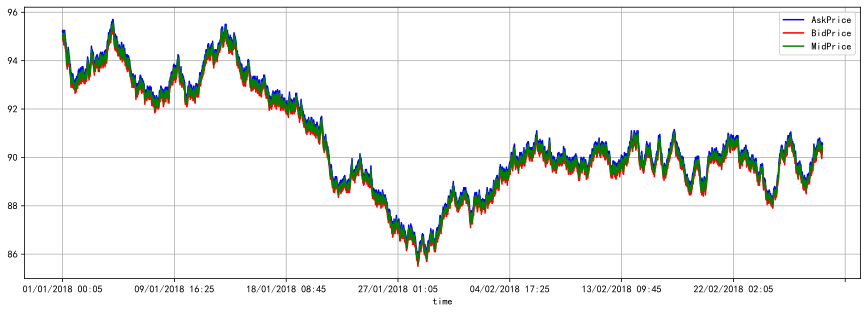

In [118]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
market_data['MM'][['AskPrice', 'BidPrice', 'MidPrice']].plot(kind='line',color=['b','r','g'],ax=ax, label=["Ask Price", "Mid Price", "Bid Price"], legend=True, grid=True)

In [119]:
%%time
# Obtain the statistical parameters for each and every pair
data_analysis = {'Pairs': [],
                 'Constant': [],
                 'Gamma': [],
                 'Alpha': [],
                 'P-Value': []}

data_zvalues = {}

for stock1 in stock_names:
    for stock2 in stock_names:
        if stock1 != stock2:
            if (stock2, stock1) in data_analysis['Pairs']:
                continue

            pairs = stock1, stock2
            constant = fit_ols(np.log(market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))[0]
            gamma = fit_ols(np.log(market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))[1]
            alpha = fit_ols(np.log(market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))[2]
            pvalue = granger_cointegration_test(np.log(market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))[1]
            zvalue = fit_ols(np.log(market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))[3]

            data_analysis['Pairs'].append(pairs)
            data_analysis['Constant'].append(constant)
            data_analysis['Gamma'].append(gamma)
            data_analysis['Alpha'].append(alpha)
            data_analysis['P-Value'].append(pvalue)

            data_zvalues[pairs] = zvalue
            
data_analysis = round(pd.DataFrame(data_analysis),4).set_index('Pairs')

Wall time: 4.44 s


In [120]:
data_analysis

Constant   Gamma   Alpha  P-Value
Pairs                                      
(AA, BB)    4.2082  0.0571 -0.0001   0.5739
(AA, CC)    6.4143 -0.4308 -0.0001   0.9207
(AA, DD)    4.2125  0.0540 -0.0001   0.6103
(AA, EE)   15.0252 -2.1503 -0.0003   0.2186
(AA, FF)   10.6286 -1.3206 -0.0002   0.4687
...            ...     ...     ...      ...
(LL, NN)    4.7110 -0.0034 -0.0005   0.2644
(LL, OO)    3.8857  0.1790 -0.0005   0.2344
(MM, NN)   -2.9034  1.5153 -0.0002   0.0000
(MM, OO)    7.3161 -0.6221 -0.0005   0.2670
(NN, OO)    6.6277 -0.3847 -0.0005   0.2389

[105 rows x 4 columns]

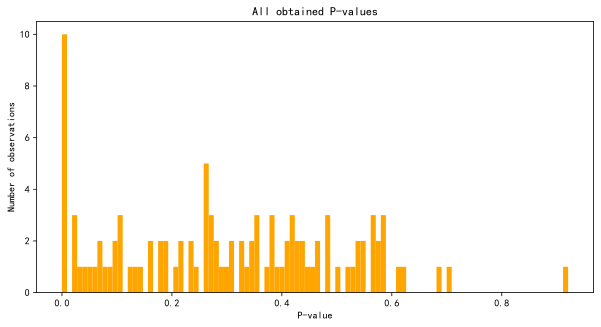

In [121]:
# Visualize the P-values
def plot_pvalues():
    """
    This function plots all obtained P-values.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(data_analysis['P-Value'], bins=100, color='orange')
    plt.xlabel('P-value')
    plt.ylabel('Number of observations')
    plt.title('All obtained P-values')
    plt.show()

plot_pvalues()

In [122]:
# Show Top 10 and Bottom 10
display(data_analysis.sort_values('P-Value')[:10])
display(data_analysis.sort_values('P-Value')[-10:])

Constant   Gamma   Alpha  P-Value
Pairs                                      
(FF, NN)   -2.6104  1.4881 -0.0022   0.0000
(FF, MM)    0.3061  0.9676 -0.0338   0.0000
(BB, DD)   -2.4182  1.4758 -0.0075   0.0000
(DD, HH)   -1.6797  1.2787 -0.0040   0.0000
(BB, JJ)   -2.4809  1.6206 -0.0000   0.0000
(DD, JJ)    0.2277  1.0356  0.0002   0.0000
(MM, NN)   -2.9034  1.5153 -0.0002   0.0000
(BB, HH)   -4.8181  1.8712 -0.0024   0.0009
(HH, JJ)    1.9492  0.7041 -0.0002   0.0010
(AA, II)    0.0445  0.9944 -0.0002   0.0031

Constant   Gamma   Alpha  P-Value
Pairs                                      
(AA, BB)    4.2082  0.0571 -0.0001   0.5739
(EE, JJ)    5.0700 -0.0369 -0.0002   0.5765
(AA, MM)   10.2964 -1.2938 -0.0001   0.5812
(AA, KK)    9.7238 -1.1233 -0.0001   0.5826
(AA, JJ)    4.1324  0.0773 -0.0001   0.5860
(AA, DD)    4.2125  0.0540 -0.0001   0.6103
(CC, EE)    1.7955  0.5551 -0.0002   0.6199
(CC, OO)    8.4182 -0.8627 -0.0002   0.6888
(CC, GG)    2.8739  0.3184 -0.0002   0.7055
(AA, CC)    6.4143 -0.4308 -0.0001   0.9207

In [123]:
# Selecting tradable pairs where P-Value < 0.01 and create a seperate DataFrame containing these pairs
tradable_pairs_analysis = data_analysis[data_analysis['P-Value'] < 0.01].sort_values('P-Value')

tradable_pairs_analysis

Constant   Gamma   Alpha  P-Value
Pairs                                      
(BB, DD)   -2.4182  1.4758 -0.0075   0.0000
(BB, JJ)   -2.4809  1.6206 -0.0000   0.0000
(DD, HH)   -1.6797  1.2787 -0.0040   0.0000
(DD, JJ)    0.2277  1.0356  0.0002   0.0000
(FF, MM)    0.3061  0.9676 -0.0338   0.0000
(FF, NN)   -2.6104  1.4881 -0.0022   0.0000
(MM, NN)   -2.9034  1.5153 -0.0002   0.0000
(BB, HH)   -4.8181  1.8712 -0.0024   0.0009
(HH, JJ)    1.9492  0.7041 -0.0002   0.0010
(AA, II)    0.0445  0.9944 -0.0002   0.0031

In [124]:
# Get all the tradable stock pairs into a list
stock_pairs = list(tradable_pairs_analysis.index.values.tolist())

# Show the Pairs
stock_pairs

[('BB', 'DD'),
 ('BB', 'JJ'),
 ('DD', 'HH'),
 ('DD', 'JJ'),
 ('FF', 'MM'),
 ('FF', 'NN'),
 ('MM', 'NN'),
 ('BB', 'HH'),
 ('HH', 'JJ'),
 ('AA', 'II')]

We now build further on the Data Analysis section by zooming in onto the pairs and calculate additional data on the error correction terms.

In [125]:
# Create a list of unique tradable stocks
list_stock1 = [stock[0] for stock in stock_pairs]
list_stock2 = [stock[1] for stock in stock_pairs]

for stock in list_stock2:
    list_stock1.append(stock)
    
unique_stock_list = list(set(list_stock1))

# Create a new DataFrame containing all market information for the tradable pairs
tradable_pairs_data = market_data[unique_stock_list]
tradable_pairs_data.head()

NN                                             FF                                        ...       DD                                             JJ  \
                 AskPrice AskVolume BidPrice BidVolume MidPrice AskPrice AskVolume BidPrice BidVolume MidPrice  ... AskPrice AskVolume BidPrice BidVolume MidPrice AskPrice   
time                                                                                                            ...                                                           
01/01/2018 00:05   137.60       122   137.20       122  137.400   111.75       118   111.45       118  111.600  ...   117.30       102   116.95       102  117.125    80.05   
01/01/2018 00:10   137.55       110   137.20       111  137.375   111.80       109   111.50       115  111.650  ...   117.25       103   116.95        98  117.100    80.00   
01/01/2018 00:15   137.65       106   137.25       117  137.450   111.90        97   111.55       101  111.725  ...   117.20       113   116.90       109  117.050    79.90   
01/01/2018 00:20   137.65        97   137.25       107  137.450   111.95        98   111.60       102  111.775  ...   117.30       117   116.95       100  117.125    79.95   
01/01/2018 00:25   137.60       109   137.15       111  137.375   111.95        97   111.60       102  111.775  ...   117.30       129   116.95       106  117.125    79.95   

                                                        
                 AskVolume BidPrice BidVolume MidPrice  
time                                                    
01/01/2018 00:05       156    79.80       156   79.925  
01/01/2018 00:10       161    79.75       157   79.875  
01/01/2018 00:15       145    79.65       152   79.775  
01/01/2018 00:20       140    79.65       154   79.800  
01/01/2018 00:25       137    79.65       158   79.800  

[5 rows x 45 columns]

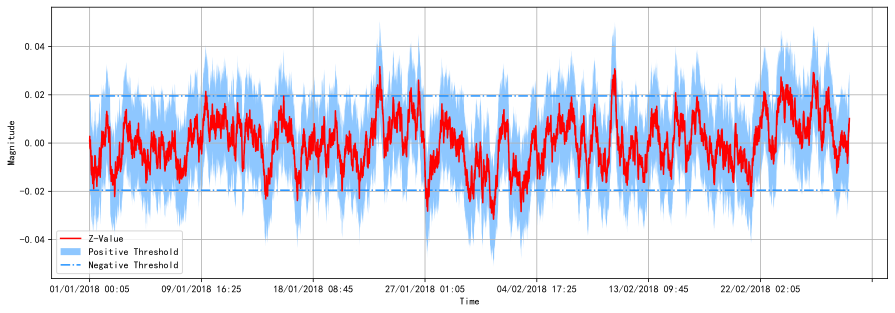

In [126]:
for pair in stock_pairs[:1]: 
    zvalue = data_zvalues[pair]
    plt.figure(figsize=(15,5))
    # plt.title('Error-correction term stock pair {}'.format(pair))
    zvalue.plot(color='r')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    lower = np.array(zvalue) - 1.96*zvalue.std()
    upper = np.array(zvalue) + 1.96*zvalue.std()
    plt.fill_between(x=zvalue.index, y1=lower, y2=upper, facecolor="dodgerblue", alpha=0.5)
    xmin = 0
    xmax = len(zvalue)
    plt.hlines(zvalue.mean()+1.96*zvalue.std(), xmin, xmax, colors='dodgerblue', linestyles='dashdot') 
    plt.hlines(zvalue.mean()-1.96*zvalue.std(), xmin, xmax, 'dodgerblue', linestyles='dashdot') 
    plt.legend(['Z-Value', 'Positive Threshold', 'Negative Threshold'], loc='lower left')
    plt.grid(True)
    # plt.savefig("./imgs/res_%s_%s"%(pair[0], pair[1]), dpi=400)
    plt.show()


In [75]:
# Select randomly chosen pair from the tradable stock and visualize bid and ask prices, bid and ask volumes, and the z-values
import random

# Choose random stock
random_pair = random.choice(stock_pairs)

# Create a plot showing the bid and ask prices of a randomly chosen stock
def Plot_RandomPair_BidAskPrices():
    """
    This function plots the bid and ask price of a randomly chosen tradable pair.
    """
    plt.figure(figsize=(12,5))
    plt.title('Bid and ask prices of stock pair {} and {}'.format(random_pair[0], random_pair[1]))
    
    # plt.plot(tradable_pairs_data[random_pair[0], 'AskPrice'].iloc[:100], 'r')
    plt.plot(tradable_pairs_data[random_pair[0], 'BidPrice'].iloc[:100], 'g')
    plt.xlabel('Time')
    plt.ylabel('Price stock {}'.format(random_pair[0]))
    plt.legend(loc='lower left')
    
    plt.twinx()
    # plt.plot(tradable_pairs_data[random_pair[1], 'AskPrice'].iloc[:100], 'r')
    plt.plot(tradable_pairs_data[random_pair[1], 'BidPrice'].iloc[:100], 'g')
    plt.xticks([])
    plt.ylabel('Price stock {}'.format(random_pair[1]))
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.show()

Plot_RandomPair_BidAskPrices()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


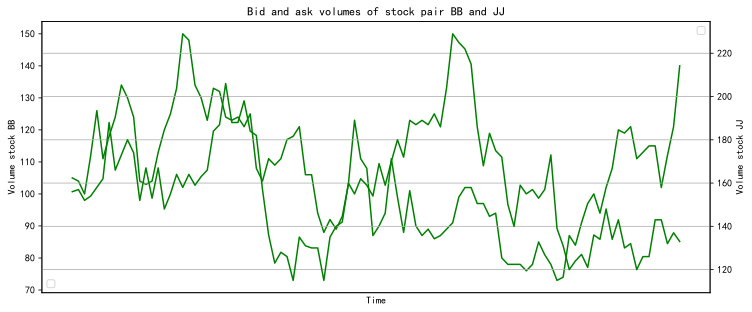

In [76]:
# Create a plot showing the bid and ask volumes of a randomly chosen stock
def Plot_RandomPair_BidAskVolumes(): # Plot not really clarifying, maybe other kind of plot?
    """
    This function plots the bid and ask volumes of a randomly chosen tradable pair.
    """
    plt.figure(figsize=(12,5))
    plt.title('Bid and ask volumes of stock pair {} and {}'.format(random_pair[0],random_pair[1]))
    
    # plt.plot(tradable_pairs_data[random_pair[0], 'AskVolume'].iloc[:100], 'r')
    plt.plot(tradable_pairs_data[random_pair[0], 'BidVolume'].iloc[:100], 'g')
    plt.xlabel('Time')
    plt.ylabel('Volume stock {}'.format(random_pair[0]))
    plt.legend(loc='lower left')
    
    plt.twinx()
    # plt.plot(tradable_pairs_data[random_pair[1], 'AskVolume'].iloc[:100], 'r')
    plt.plot(tradable_pairs_data[random_pair[1], 'BidVolume'].iloc[:100], 'g')
    plt.xticks([])
    plt.ylabel('Volume stock {}'.format(random_pair[1]))
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.show()

Plot_RandomPair_BidAskVolumes()

In [127]:
# Create a Dataframe containing information about the error-correction term of each pair
data_error_correction_term = {'Pair': [],
                              'CountZeroCrossings': [],
                              'TradingPeriod': [],
                              'LongRunMean': [],
                              'Std': []}

for pair in stock_pairs:
    zvalue = data_zvalues[pair]
    my_array = np.array(zvalue)
    count = ((my_array[:-1] * my_array[1:]) < 0).sum()
    trading_period = 1 / count
    long_run_mean = zvalue.mean()
    std = zvalue.std()

    data_error_correction_term['Pair'].append(pair)
    data_error_correction_term['CountZeroCrossings'].append(count)
    data_error_correction_term['TradingPeriod'].append(trading_period)
    data_error_correction_term['LongRunMean'].append(round(long_run_mean, 4))
    data_error_correction_term['Std'].append(round(std, 4))

data_error_correction_term = pd.DataFrame(data_error_correction_term).set_index('Pair')

data_error_correction_term

CountZeroCrossings  TradingPeriod  LongRunMean     Std
Pair                                                            
(BB, DD)                 660       0.001515         -0.0  0.0100
(BB, JJ)                1475       0.000678          0.0  0.0044
(DD, HH)                 396       0.002525          0.0  0.0097
(DD, JJ)                 592       0.001689         -0.0  0.0072
(FF, MM)                1413       0.000708         -0.0  0.0031
(FF, NN)                 705       0.001418          0.0  0.0061
(MM, NN)                 627       0.001595         -0.0  0.0068
(BB, HH)                 334       0.002994         -0.0  0.0181
(HH, JJ)                 363       0.002755          0.0  0.0090
(AA, II)                 363       0.002755          0.0  0.0214

**Threshold Analysis for All Stock Pairs**

This section is for discovering what threshold would maximize profits for a given pair. We did many loops over different thresholds to find the ideal level. In the next section, the pairs with the highest profits those that are unique (prevent having a stock as 'BB' be traded twice) will be picked to determine the final profit

In [128]:
# Create a new column within the earlier defined DataFrame with Z-Values of all stock pairs
for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    tradable_pairs_data[stock1+stock2, 'Z-Value'] = data_zvalues[stock1,stock2]

In [129]:
tradable_pairs_data

NN                                             FF                                        ...      BBDD      BBJJ      DDHH      DDJJ      FFMM      FFNN  \
                 AskPrice AskVolume BidPrice BidVolume MidPrice AskPrice AskVolume BidPrice BidVolume MidPrice  ...   Z-Value   Z-Value   Z-Value   Z-Value   Z-Value   Z-Value   
time                                                                                                            ...                                                               
01/01/2018 00:05   137.60       122   137.20       122  137.400   111.75       118   111.45       118  111.600  ...  0.000798 -0.006871  0.000814 -0.001543  0.001858 -0.000489   
01/01/2018 00:10   137.55       110   137.20       111  137.375   111.80       109   111.50       115  111.650  ...  0.000617 -0.006354  0.001222 -0.001109  0.002306  0.000230   
01/01/2018 00:15   137.65       106   137.25       117  137.450   111.90        97   111.55       101  111.725  ...  0.002736 -0.002834  0.000795 -0.000238  0.002468  0.000089   
01/01/2018 00:20   137.65        97   137.25       107  137.450   111.95        98   111.60       102  111.775  ...  0.002782 -0.002350  0.001643  0.000078  0.002661  0.000537   
01/01/2018 00:25   137.60       109   137.15       111  137.375   111.95        97   111.60       102  111.775  ...  0.001046 -0.004086  0.001851  0.000078  0.003170  0.001349   
...                   ...       ...      ...       ...      ...      ...       ...      ...       ...      ...  ...       ...       ...       ...       ...       ...       ...   
28/02/2018 23:35   132.60       145   132.20       174  132.400   105.90       140   105.60       123  105.750  ...  0.008534 -0.000280  0.002309 -0.004466 -0.003719  0.000830   
28/02/2018 23:40   132.60       142   132.25       188  132.425   105.95       126   105.60       128  105.775  ...  0.008534  0.000770  0.001240 -0.003795 -0.004017  0.000786   
28/02/2018 23:45   132.60       147   132.25       174  132.425   105.90       118   105.55       116  105.725  ...  0.009189  0.002871  0.001651 -0.002896 -0.003687  0.000313   
28/02/2018 23:50   132.45       149   132.10       153  132.275   105.90       112   105.55       111  105.725  ...  0.009710  0.002867  0.001651 -0.003232 -0.003955  0.001999   
28/02/2018 23:55   132.50       126   132.15       153  132.325   105.80       112   105.50       103  105.650  ...  0.010172  0.002346  0.000771 -0.003898 -0.004397  0.000727   

                      MMNN      BBHH      HHJJ      AAII  
                   Z-Value   Z-Value   Z-Value   Z-Value  
time                                                      
01/01/2018 00:05 -0.001675  0.002720  0.004344 -0.063167  
01/01/2018 00:10 -0.001399  0.003133  0.004298 -0.062007  
01/01/2018 00:15 -0.001701  0.004623  0.005180 -0.062319  
01/01/2018 00:20 -0.001438  0.005918  0.004797 -0.064416  
01/01/2018 00:25 -0.001136  0.004485  0.004635 -0.065025  
...                    ...       ...       ...       ...  
28/02/2018 23:35  0.004611  0.012166 -0.002748  0.011450  
28/02/2018 23:40  0.004878  0.010602 -0.001456  0.011450  
28/02/2018 23:45  0.004049  0.011853 -0.001212  0.009817  
28/02/2018 23:50  0.006042  0.012374 -0.001440  0.009285  
28/02/2018 23:55  0.005193  0.011540 -0.001273  0.009535  

[16991 rows x 55 columns]

In [130]:
# Create a Dictionary that saves all Gamma values of each pair
gamma_dictionary = {}

for pair, value in tradable_pairs_analysis.iterrows():
    gamma_dictionary[pair]= value['Gamma']
    
gamma_dictionary

{('BB', 'DD'): 1.4758,
 ('BB', 'JJ'): 1.6206,
 ('DD', 'HH'): 1.2787,
 ('DD', 'JJ'): 1.0356,
 ('FF', 'MM'): 0.9676,
 ('FF', 'NN'): 1.4881,
 ('MM', 'NN'): 1.5153,
 ('BB', 'HH'): 1.8712,
 ('HH', 'JJ'): 0.7041,
 ('AA', 'II'): 0.9944}

In [131]:
# Create a Dictionary that saves all Standard Deviation values of each pair
std_dictionary = {}

for pair, value in data_error_correction_term.iterrows():
    std_dictionary[pair]= value['Std']
    
std_dictionary

{('BB', 'DD'): 0.01,
 ('BB', 'JJ'): 0.0044,
 ('DD', 'HH'): 0.0097,
 ('DD', 'JJ'): 0.0072,
 ('FF', 'MM'): 0.0031,
 ('FF', 'NN'): 0.0061,
 ('MM', 'NN'): 0.0068,
 ('BB', 'HH'): 0.0181,
 ('HH', 'JJ'): 0.009,
 ('AA', 'II'): 0.0214}

This is our Algorithm for finding the correct thresholds that are able to generate the greatest amount of profit. We find it important to <b>not</b> <i>maximize</i> the profit because what holds for historic data is not guaranteed to hold for future data. We therefore specify a limited selection of thresholds with a linspace.

In [132]:
%%time

from tqdm import tqdm
from joblib import Parallel, delayed

# positions = {}
limit = 100

def test_thre(pair):
    positions = {}
    stock1 = pair[0]
    stock2 = pair[1]
    
    gamma = gamma_dictionary[stock1,stock2]
    
    for i in tqdm(np.linspace(0.05, 1.0, 10)):
        threshold = i * std_dictionary[stock1,stock2]
        
        current_position_stock1 = 0 
        current_position_stock2 = 0 
        
        column_name_stock1 = stock1 + ' Pos - Thres: ' + str(threshold)
        
        BidPrice_Stock1 = tradable_pairs_data[stock1,'BidVolume'][0]
        AskPrice_Stock1 = tradable_pairs_data[stock1,'AskVolume'][0]
        BidPrice_Stock2 = tradable_pairs_data[stock2,'BidVolume'][0]
        AskPrice_Stock2 = tradable_pairs_data[stock1,'AskVolume'][0]
        
        positions[column_name_stock1] = []
        
        for time, data_at_time in tradable_pairs_data.iterrows():
            
            BidVolume_Stock1 = data_at_time[stock1, 'BidVolume']
            AskVolume_Stock1 = data_at_time[stock1, 'AskVolume']
            BidVolume_Stock2 = data_at_time[stock2, 'BidVolume']
            AskVolume_Stock2 = data_at_time[stock2, 'AskVolume']
            
            zvalue = data_at_time[stock1+stock2,'Z-Value']

            # If the zvalues of (BB,DD) are high the spread diverges, i.e. sell BB (=stock1=y) and buy DD (=stock2=x)
            if zvalue >= threshold:
                hedge_ratio = gamma * (BidPrice_Stock1 / AskPrice_Stock2)
                
                if hedge_ratio >= 1:

                    max_order_stock1 = current_position_stock1 + limit
                    max_order_stock2 = max_order_stock1 / hedge_ratio

                    trade = np.floor(min((BidVolume_Stock1 / hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((- trade * hedge_ratio) + current_position_stock1)

                    current_position_stock1 = ((- trade * hedge_ratio) + current_position_stock1)
                
                elif hedge_ratio < 1:

                    max_order_stock1 = current_position_stock1 + limit
                    max_order_stock2 = max_order_stock1 * hedge_ratio

                    trade = np.floor(min((BidVolume_Stock1 * hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((- trade / hedge_ratio) + current_position_stock1)

                    current_position_stock1 = ((- trade / hedge_ratio) + current_position_stock1)

            elif zvalue <= -threshold:
                hedge_ratio = gamma * (AskPrice_Stock1 / BidPrice_Stock2)
                
                if hedge_ratio >= 1:

                    max_order_stock1 = abs(current_position_stock1 - limit)
                    max_order_stock2 = max_order_stock1 / hedge_ratio

                    trade = np.floor(min((AskVolume_Stock1 / hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((+ trade * hedge_ratio) + current_position_stock1)

                    current_position_stock1 = (+ trade * hedge_ratio) + current_position_stock1

                elif hedge_ratio < 1:
                    
                    max_order_stock1 = abs(current_position_stock1 - limit)
                    max_order_stock2 = max_order_stock1 * hedge_ratio

                    trade = np.floor(min((AskVolume_Stock1 * hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((+ trade / hedge_ratio) + current_position_stock1)

                    current_position_stock1 = (+ trade / hedge_ratio) + current_position_stock1  
                
                BidPrice_Stock1 = data_at_time[stock1, 'BidPrice']
                AskPrice_Stock1 = data_at_time[stock1, 'AskPrice']
                BidPrice_Stock2 = data_at_time[stock2, 'BidPrice']
                AskPrice_Stock2 = data_at_time[stock2, 'AskPrice']

            else:
                    positions[column_name_stock1].append(current_position_stock1)
        
        column_name_stock2 = stock2 + ' Pos - Thres: ' + str(threshold)
        
        if hedge_ratio >= 1:
            positions[column_name_stock2] = positions[column_name_stock1] / hedge_ratio * -1
        
        elif hedge_ratio < 1:
            positions[column_name_stock2] = positions[column_name_stock1] / (1 / hedge_ratio) * -1

    return pd.DataFrame(positions)
        
pos = Parallel(n_jobs=-1)(delayed(test_thre)(pair) for pair in tqdm(stock_pairs))


100%|██████████| 10/10 [00:00<00:00, 10015.05it/s]


Wall time: 38.1 s


In [133]:
positions = pd.concat(pos, axis=1)
positions

BB Pos - Thres: 0.0005  DD Pos - Thres: 0.0005  BB Pos - Thres: 0.0015555555555555557  DD Pos - Thres: 0.0015555555555555557  BB Pos - Thres: 0.0026111111111111114  \
0                  -98.878600               79.586604                               0.000000                              -0.000000                               0.000000   
1                  -98.878600               79.586604                               0.000000                              -0.000000                               0.000000   
2                  -98.878600               79.586604                             -98.878600                              79.586604                             -98.878600   
3                  -98.878600               79.586604                             -98.878600                              79.586604                             -98.878600   
4                  -98.878600               79.586604                             -98.878600                              79.586604                             -98.878600   
...                       ...                     ...                                    ...                                    ...                                    ...   
16986              -99.301936               79.927343                             -99.643076                              80.201924                             -98.769035   
16987              -99.301936               79.927343                             -99.643076                              80.201924                             -98.769035   
16988              -99.301936               79.927343                             -99.643076                              80.201924                             -98.769035   
16989              -99.301936               79.927343                             -99.643076                              80.201924                             -98.769035   
16990              -99.301936               79.927343                             -99.643076                              80.201924                             -98.769035   

       DD Pos - Thres: 0.0026111111111111114  BB Pos - Thres: 0.0036666666666666666  DD Pos - Thres: 0.0036666666666666666  BB Pos - Thres: 0.004722222222222222  \
0                                  -0.000000                               0.000000                              -0.000000                              0.000000   
1                                  -0.000000                               0.000000                              -0.000000                              0.000000   
2                                  79.615063                               0.000000                              -0.000000                              0.000000   
3                                  79.615063                               0.000000                              -0.000000                              0.000000   
4                                  79.615063                               0.000000                              -0.000000                              0.000000   
...                                      ...                                    ...                                    ...                                   ...   
16986                              79.526843                             -99.918685                              80.536761                            -99.712776   
16987                              79.526843                             -99.918685                              80.536761                            -99.712776   
16988                              79.526843                             -99.918685                              80.536761                            -99.712776   
16989                              79.526843                             -99.918685                              80.536761                            -99.712776   
16990                              79.526843                             -99.918685                              8

In [134]:
# Create a seperate dataframe (to keep the original dataframe intact) with rounding
# Also insert the timestamp, as found in the tradeable_pairs_data DataFrame
positions_final = np.ceil(pd.DataFrame(positions))
positions_final['Timestamp'] = tradable_pairs_data.index
positions_final = positions_final.set_index('Timestamp')
positions_final

BB Pos - Thres: 0.0005  DD Pos - Thres: 0.0005  BB Pos - Thres: 0.0015555555555555557  DD Pos - Thres: 0.0015555555555555557  \
Timestamp                                                                                                                                        
01/01/2018 00:05                   -98.0                    80.0                                    0.0                                   -0.0   
01/01/2018 00:10                   -98.0                    80.0                                    0.0                                   -0.0   
01/01/2018 00:15                   -98.0                    80.0                                  -98.0                                   80.0   
01/01/2018 00:20                   -98.0                    80.0                                  -98.0                                   80.0   
01/01/2018 00:25                   -98.0                    80.0                                  -98.0                                   80.0   
...                                  ...                     ...                                    ...                                    ...   
28/02/2018 23:35                   -99.0                    80.0                                  -99.0                                   81.0   
28/02/2018 23:40                   -99.0                    80.0                                  -99.0                                   81.0   
28/02/2018 23:45                   -99.0                    80.0                                  -99.0                                   81.0   
28/02/2018 23:50                   -99.0                    80.0                                  -99.0                                   81.0   
28/02/2018 23:55                   -99.0                    80.0                                  -99.0                                   81.0   

                  BB Pos - Thres: 0.0026111111111111114  DD Pos - Thres: 0.0026111111111111114  BB Pos - Thres: 0.0036666666666666666  DD Pos - Thres: 0.0036666666666666666  \
Timestamp                                                                                                                                                                      
01/01/2018 00:05                                    0.0                                   -0.0                                    0.0                                   -0.0   
01/01/2018 00:10                                    0.0                                   -0.0                                    0.0                                   -0.0   
01/01/2018 00:15                                  -98.0                                   80.0                                    0.0                                   -0.0   
01/01/2018 00:20                                  -98.0                                   80.0                                    0.0                                   -0.0   
01/01/2018 00:25                                  -98.0                                   80.0                                    0.0                                   -0.0   
...                                                 ...                                    ...                                    ...                                    ...   
28/02/2018 23:35                                  -98.0                                   80.0                                  -99.0                                   81.0   
28/02/2018 23:40                                  -98.0                                   80.0                                  -99.0                                   81.0   
28/02/2018 23:45                                  -98.0                                   80.0                                  -99.0                                   81.0   
28/02/2018 23:50                                  -98.0                                   80.0                                  -99.0                                   81.0   
28/02/2

In [135]:
# The difference between the positions
positions_diff = positions_final.diff()[1:]

positions_diff[(positions_diff != 0)].count().to_excel('./res/pos_thresholds.xlsx')

positions_diff

BB Pos - Thres: 0.0005  DD Pos - Thres: 0.0005  BB Pos - Thres: 0.0015555555555555557  DD Pos - Thres: 0.0015555555555555557  \
Timestamp                                                                                                                                        
01/01/2018 00:10                     0.0                     0.0                                    0.0                                    0.0   
01/01/2018 00:15                     0.0                     0.0                                  -98.0                                   80.0   
01/01/2018 00:20                     0.0                     0.0                                    0.0                                    0.0   
01/01/2018 00:25                     0.0                     0.0                                    0.0                                    0.0   
01/01/2018 00:30                   132.0                  -106.0                                    0.0                                    0.0   
...                                  ...                     ...                                    ...                                    ...   
28/02/2018 23:35                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:40                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:45                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:50                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:55                     0.0                     0.0                                    0.0                                    0.0   

                  BB Pos - Thres: 0.0026111111111111114  DD Pos - Thres: 0.0026111111111111114  BB Pos - Thres: 0.0036666666666666666  DD Pos - Thres: 0.0036666666666666666  \
Timestamp                                                                                                                                                                      
01/01/2018 00:10                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:15                                  -98.0                                   80.0                                    0.0                                    0.0   
01/01/2018 00:20                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:25                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:30                                    0.0                                    0.0                                    0.0                                    0.0   
...                                                 ...                                    ...                                    ...                                    ...   
28/02/2018 23:35                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2018 23:40                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2018 23:45                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2018 23:50                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2

In [136]:
positions_diff[(positions_diff != 0)].count()

BB Pos - Thres: 0.0005                   831
DD Pos - Thres: 0.0005                   831
BB Pos - Thres: 0.0015555555555555557    416
DD Pos - Thres: 0.0015555555555555557    416
BB Pos - Thres: 0.0026111111111111114    297
                                        ... 
II Pos - Thres: 0.016882222222222222       5
AA Pos - Thres: 0.019141111111111112       4
II Pos - Thres: 0.019141111111111112       4
AA Pos - Thres: 0.0214                     5
II Pos - Thres: 0.0214                     5
Length: 200, dtype: int64

This method is used to value our last position by the correct market value. This to ensure that in the time between our last trade and the last timestamp does not hold any secrets (a market crash for example) that are not calculated in the PnL. One could say the profit is for example €50.000 while it is actually far lower because our positions are worth next to nothing due to a market crash.

In [137]:
positions_diff[-1:] = -positions_final[-1:]

To determine which threshold is the most profitable, we determine the PnL of each combination of pair and threshold. 

In [138]:
positions_diff

BB Pos - Thres: 0.0005  DD Pos - Thres: 0.0005  BB Pos - Thres: 0.0015555555555555557  DD Pos - Thres: 0.0015555555555555557  \
Timestamp                                                                                                                                        
01/01/2018 00:10                     0.0                     0.0                                    0.0                                    0.0   
01/01/2018 00:15                     0.0                     0.0                                  -98.0                                   80.0   
01/01/2018 00:20                     0.0                     0.0                                    0.0                                    0.0   
01/01/2018 00:25                     0.0                     0.0                                    0.0                                    0.0   
01/01/2018 00:30                   132.0                  -106.0                                    0.0                                    0.0   
...                                  ...                     ...                                    ...                                    ...   
28/02/2018 23:35                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:40                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:45                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:50                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:55                    99.0                   -80.0                                   99.0                                  -81.0   

                  BB Pos - Thres: 0.0026111111111111114  DD Pos - Thres: 0.0026111111111111114  BB Pos - Thres: 0.0036666666666666666  DD Pos - Thres: 0.0036666666666666666  \
Timestamp                                                                                                                                                                      
01/01/2018 00:10                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:15                                  -98.0                                   80.0                                    0.0                                    0.0   
01/01/2018 00:20                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:25                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:30                                    0.0                                    0.0                                    0.0                                    0.0   
...                                                 ...                                    ...                                    ...                                    ...   
28/02/2018 23:35                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2018 23:40                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2018 23:45                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2018 23:50                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2

In [139]:
pnl_dataframe = pd.DataFrame()

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]

    Stock1_AskPrice = tradable_pairs_data[stock1, 'AskPrice'][1:]
    Stock1_BidPrice = tradable_pairs_data[stock1, 'BidPrice'][1:]
    Stock2_AskPrice = tradable_pairs_data[stock2, 'AskPrice'][1:]
    Stock2_BidPrice = tradable_pairs_data[stock2, 'BidPrice'][1:]

    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1, stock2]

        column_name_1 = stock1 + ' Pos - Thres: ' + str(threshold)
        column_name_2 = stock2 + ' Pos - Thres: ' + str(threshold)

        pnl_dataframe[stock1 + str(threshold)] = np.where(positions_diff[column_name_1] > 0,
                                                          positions_diff[column_name_1] * -Stock1_BidPrice, positions_diff[column_name_1] * -Stock1_AskPrice)
        pnl_dataframe[stock2 + str(threshold)] = np.where(positions_diff[column_name_2] > 0,
                                                          positions_diff[column_name_2] * -Stock2_BidPrice, positions_diff[column_name_2] * -Stock2_AskPrice)

pnl_dataframe

BB0.0005  DD0.0005  BB0.0015555555555555557  DD0.0015555555555555557  BB0.0026111111111111114  DD0.0026111111111111114  BB0.0036666666666666666  DD0.0036666666666666666  \
0         -0.00      -0.0                    -0.00                    -0.00                     -0.0                     -0.0                    -0.00                    -0.00   
1         -0.00      -0.0                  9893.10                 -9352.00                   9893.1                  -9352.0                    -0.00                    -0.00   
2         -0.00      -0.0                    -0.00                    -0.00                     -0.0                     -0.0                    -0.00                    -0.00   
3         -0.00      -0.0                    -0.00                    -0.00                     -0.0                     -0.0                    -0.00                    -0.00   
4     -13259.40   12439.1                    -0.00                    -0.00                     -0.0                     -0.0                    -0.00                    -0.00   
...         ...       ...                      ...                      ...                      ...                      ...                      ...                      ...   
16985     -0.00      -0.0                    -0.00                    -0.00                     -0.0                     -0.0                    -0.00                    -0.00   
16986     -0.00      -0.0                    -0.00                    -0.00                     -0.0                     -0.0                    -0.00                    -0.00   
16987     -0.00      -0.0                    -0.00                    -0.00                     -0.0                     -0.0                    -0.00                    -0.00   
16988     -0.00      -0.0                    -0.00                    -0.00                     -0.0                     -0.0                    -0.00                    -0.00   
16989  -9479.25    9020.0                 -9479.25                  9132.75                  -9383.5                   9020.0                 -9479.25                  9132.75   

       BB0.004722222222222222  DD0.004722222222222222  ...  AA0.012364444444444445  II0.012364444444444445  AA0.014623333333333334  II0.014623333333333334  \
0                       -0.00                   -0.00  ...                    -0.0                    -0.0                    -0.0                    -0.0   
1                       -0.00                   -0.00  ...                    -0.0                    -0.0                    -0.0                    -0.0   
2                       -0.00                   -0.00  ...                    -0.0                    -0.0                    -0.0                    -0.0   
3                       -0.00                   -0.00  ...                    -0.0                    -0.0                    -0.0                    -0.0   
4                       -0.00                   -0.00  ...                    -0.0                    -0.0                    -0.0                    -0.0   
...                       ...                     ...  ...                     ...                     ...                     ...                     ...   
16985                   -0.00                   -0.00  ...                    -0.0                    -0.0                    -0.0                    -0.0   
16986                   -0.00                   -0.00  ...                    -0.0                    -0.0                    -0.0                    -0.0   
16987                   -0.00                   -0.00  ...                    -0.0                    -0.0                    -0.0                    -0.0   
16988                   -0.00                   -0.00  ...                    -0.0                    -0.0                    -0.0                    -0.0   
16989                -9479.25                 9132.75  ...                 -9187.2                  9045.0              

In [140]:
# Create Columns for the pnl_threshold dataframe
pairs = []
thresholds = []

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]

    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1, stock2]
        pair = stock1, stock2
        pairs.append(pair)
        thresholds.append(threshold)

In [141]:
# Include columns and append PnLs
pnl_threshold = {'Pairs' : pairs,
                 'Thresholds': thresholds,
                 'PnLs' : []}

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1,stock2]
        pnl_threshold['PnLs'].append(pnl_dataframe[stock1 + str(threshold)].sum() + pnl_dataframe[stock2 + str(threshold)].sum())
        
pnl_threshold = pd.DataFrame(pnl_threshold)
pnl_threshold = pnl_threshold.set_index('Pairs')
pnl_threshold.to_excel('./res/pnl_thresholds.xlsx')
pnl_threshold

Thresholds      PnLs
Pairs                         
(BB, DD)    0.000500  26140.55
(BB, DD)    0.001556  16830.75
(BB, DD)    0.002611  14596.10
(BB, DD)    0.003667  11999.50
(BB, DD)    0.004722  11858.30
...              ...       ...
(AA, II)    0.012364   1400.25
(AA, II)    0.014623   1208.10
(AA, II)    0.016882   1083.45
(AA, II)    0.019141   1145.10
(AA, II)    0.021400   1317.00

[100 rows x 2 columns]

In [142]:
# Find Highest PnLs
highest_pnls = pnl_threshold.groupby(by='Pairs').agg({'PnLs' : max})
highest_pnls.sort_values('PnLs', ascending=False)

PnLs
Pairs             
(FF, MM)  59186.40
(BB, JJ)  46740.30
(FF, NN)  29441.50
(BB, DD)  26140.55
(MM, NN)  21508.00
(DD, JJ)  19887.50
(DD, HH)  19541.65
(BB, HH)  16306.90
(AA, II)  10433.60
(HH, JJ)   5390.10

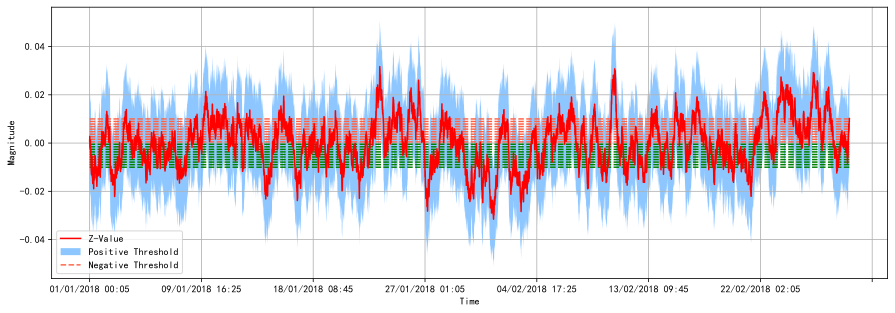

In [143]:
def Plot_Thresholds(stock1, stock2):
    zvalue = tradable_pairs_data[stock1+stock2,'Z-Value']
    plt.figure(figsize=(15,5))
    # plt.title('Error-correction term stock pair ' + stock1 + ' and ' + stock2)
    zvalue.plot(color='r')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    lower = np.array(zvalue) - 1.96*zvalue.std()
    upper = np.array(zvalue) + 1.96*zvalue.std()
    plt.fill_between(x=zvalue.index, y1=lower, y2=upper, facecolor="dodgerblue", alpha=0.5)
    xmin = 0
    xmax = len(zvalue)
    plt.hlines(pnl_threshold[pnl_threshold.index==(stock1, stock2)]['Thresholds'], xmin, xmax, 'Tomato', linestyles='--')  
    plt.hlines(-pnl_threshold[pnl_threshold.index==(stock1, stock2)]['Thresholds'], xmin, xmax, 'g', linestyles='--')
    plt.legend(['Z-Value', 'Positive Threshold', 'Negative Threshold'], loc='lower left')
    plt.grid(True)
    # plt.savefig("./imgs/res_thre_%s_%s"%(pair[0], pair[1]), dpi=400)
    plt.show()

for pair in stock_pairs[:1]:
    Plot_Thresholds(pair[0], pair[1])


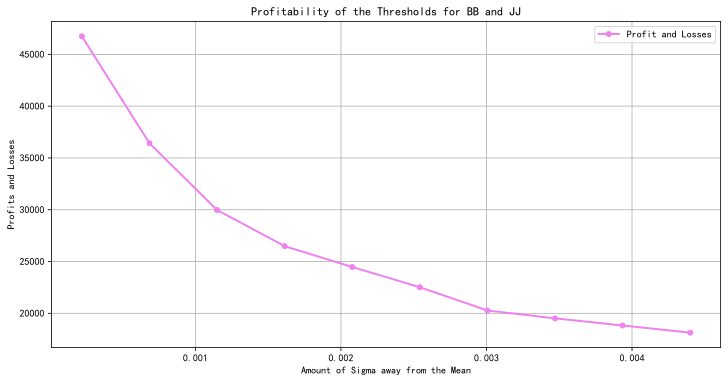

In [144]:
# Create a Plot that displays the Profitability of the Thresholds

fig, ax = plt.subplots(1,1,figsize=(15,10))

def profitability_of_the_thresholds(stock1, stock2):
    pnl_threshold[(pnl_threshold.index == (stock1, stock2))].plot(x='Thresholds', y='PnLs', figsize=(12, 6), ax=ax, color='violet', marker='o', lw=2, markersize=5)
    
    plt.title('Profitability of the Thresholds for ' + stock1 + ' and ' + stock2)
    plt.xlabel('Amount of Sigma away from the Mean')
    plt.ylabel('Profits and Losses')
    plt.legend(['Profit and Losses'])
    plt.grid()

profitability_of_the_thresholds('BB','JJ')

**Algorithm Strategy 1**

Making use of the previous analysis to determine which pairs should be traded. Based on that the algorithm, with slight modifications, is ran again to calculate the final profits.

In [145]:
# Determine the threshold, manually chosen based on pnl_threshold and ensuring no overlap.
threshold_dictionary = {('BB', 'JJ'): 0.000220,
                        ('FF', 'MM'): 0.000155,
                        ('DD', 'HH'): 0.000485,
                        ('AA', 'II'): 0.001070}

threshold_dictionary

{('BB', 'JJ'): 0.00022,
 ('FF', 'MM'): 0.000155,
 ('DD', 'HH'): 0.000485,
 ('AA', 'II'): 0.00107}

In [146]:
# Selection of the final pairs for this trading strategy
stock_pairs_final = [('BB', 'JJ'),
                     ('FF', 'MM'),
                     ('DD', 'HH'),
                     ('AA', 'II')]

stock_pairs_final

[('BB', 'JJ'), ('FF', 'MM'), ('DD', 'HH'), ('AA', 'II')]

This algorithm is a slight modification as the previous one used. In this algorithm we incorporate the chosen pairs, with the corresponding tresholds, to determine the most optimal positions.

In [147]:
positions_strategy_1 = {}
limit = 100

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    gamma = gamma_dictionary[stock1,stock2]
    
    threshold = threshold_dictionary[stock1,stock2]
        
    current_position_stock1 = 0 
    current_position_stock2 = 0 
        
    positions_strategy_1[stock1] = []

    for time, data_at_time in tradable_pairs_data.iterrows():

        BidPrice_Stock1 = data_at_time[stock1, 'BidPrice']
        AskPrice_Stock1 = data_at_time[stock1, 'AskPrice']
        BidPrice_Stock2 = data_at_time[stock2, 'BidPrice']
        AskPrice_Stock2 = data_at_time[stock2, 'AskPrice']

        BidVolume_Stock1 = data_at_time[stock1, 'BidVolume']
        AskVolume_Stock1 = data_at_time[stock1, 'AskVolume']
        BidVolume_Stock2 = data_at_time[stock2, 'BidVolume']
        AskVolume_Stock2 = data_at_time[stock2, 'AskVolume']

        zvalue = data_at_time[stock1+stock2,'Z-Value']

        if zvalue >= threshold:
            hedge_ratio = gamma * (BidPrice_Stock1 / AskPrice_Stock2)
                
            if hedge_ratio >= 1:

                max_order_stock1 = current_position_stock1 + limit
                max_order_stock2 = max_order_stock1 / hedge_ratio

                trade = np.floor(min((BidVolume_Stock1 / hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((- trade * hedge_ratio) + current_position_stock1)

                current_position_stock1 = ((- trade * hedge_ratio) + current_position_stock1)
                
            elif hedge_ratio < 1:

                max_order_stock1 = current_position_stock1 + limit
                max_order_stock2 = max_order_stock1 * hedge_ratio

                trade = np.floor(min((BidVolume_Stock1 * hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((- trade / hedge_ratio) + current_position_stock1)

                current_position_stock1 = ((- trade / hedge_ratio) + current_position_stock1)

        elif zvalue <= -threshold:
            hedge_ratio = gamma * (AskPrice_Stock1 / BidPrice_Stock2)
                
            if hedge_ratio >= 1:

                max_order_stock1 = abs(current_position_stock1 - limit)
                max_order_stock2 = max_order_stock1 / hedge_ratio

                trade = np.floor(min((AskVolume_Stock1 / hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((+ trade * hedge_ratio) + current_position_stock1)

                current_position_stock1 = (+ trade * hedge_ratio) + current_position_stock1

            elif hedge_ratio < 1:
                    
                max_order_stock1 = abs(current_position_stock1 - limit)
                max_order_stock2 = max_order_stock1 * hedge_ratio

                trade = np.floor(min((AskVolume_Stock1 * hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((+ trade / hedge_ratio) + current_position_stock1)

                current_position_stock1 = (+ trade / hedge_ratio) + current_position_stock1   

        else:

                positions_strategy_1[stock1].append(current_position_stock1)
        
    if hedge_ratio >= 1:
        positions_strategy_1[stock2] = positions_strategy_1[stock1] / hedge_ratio * -1
        
    elif hedge_ratio < 1:
        positions_strategy_1[stock2] = positions_strategy_1[stock1] / (1 / hedge_ratio) * -1

In [148]:
# Set Ceiling (to prevent positions with not enough volume available) as well as define the timestamp
positions_strategy_1 = np.ceil(pd.DataFrame(positions_strategy_1))
positions_strategy_1['Timestamp'] = tradable_pairs_data.index
positions_strategy_1 = positions_strategy_1.set_index('Timestamp')

In [149]:
# The difference between the positions
positions_diff_strategy_1 = positions_strategy_1.diff()[1:]

# # Positions_diff first rows
# positions_diff_strategy_1.head()

In [150]:
#Used as mentioned earlier.
positions_diff_strategy_1[-1:] = -positions_strategy_1[-1:]

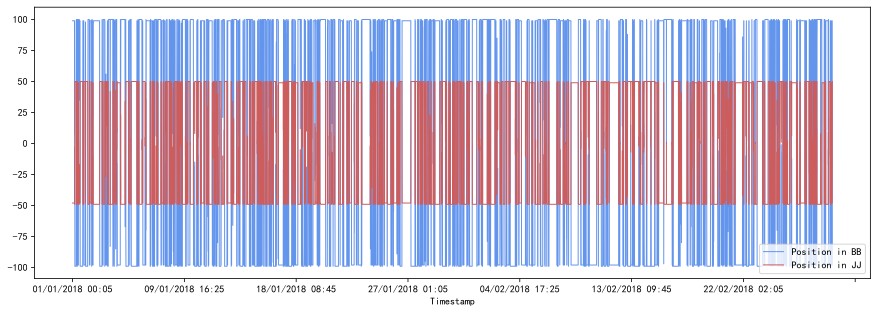

In [151]:
# Show Positions over Time
for pairs in stock_pairs_final[:1]:
    stock1 = pairs[0]
    stock2 = pairs[1]
    
    plt.figure(figsize=(15,5))
    
    positions_strategy_1[stock1].plot(color='CornflowerBlue', lw=1, markersize=3)
    positions_strategy_1[stock2].plot(color='IndianRed', lw=1, markersize=3)
    
    # plt.title('Positions over Time for ' + stock1 + ' and ' + stock2)
    plt.legend(["Position in " + stock1,"Position in " + stock2], loc='lower right')
    # plt.grid()
    # plt.savefig("./imgs/pos_%s_%s"%(stock1, stock2), dpi=500)
    plt.show()

Re-run the PnL forloop to determine the profits. This could also be manually calculated with pnl_threshold values.

In [152]:
pnl_dataframe_strategy_1 = pd.DataFrame()

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    Stock1_AskPrice = tradable_pairs_data[stock1,'AskPrice'][1:]
    Stock1_BidPrice = tradable_pairs_data[stock1,'BidPrice'][1:]
    Stock2_AskPrice = tradable_pairs_data[stock2,'AskPrice'][1:]
    Stock2_BidPrice = tradable_pairs_data[stock2,'BidPrice'][1:]

    pnl_dataframe_strategy_1[stock1] = np.where(positions_diff_strategy_1[stock1] > 0, positions_diff_strategy_1[stock1] * -Stock1_BidPrice, positions_diff_strategy_1[stock1] * -Stock1_AskPrice)
    pnl_dataframe_strategy_1[stock2] = np.where(positions_diff_strategy_1[stock2] > 0, positions_diff_strategy_1[stock2] * -Stock2_BidPrice, positions_diff_strategy_1[stock2] * -Stock2_AskPrice)

print("The total profit is: €",round(pnl_dataframe_strategy_1.sum().sum()))

The total profit is: € 135848


In [153]:
pnl_dataframe_strategy_1['Timestamp'] = tradable_pairs_data.index[1:]
pnl_dataframe_strategy_1 = pnl_dataframe_strategy_1.set_index('Timestamp')

pnl_dataframe_strategy_1['PnL'] = pnl_dataframe_strategy_1.sum(axis=1)
pnl_dataframe_strategy_1['Cum PnL'] = pnl_dataframe_strategy_1['PnL'].cumsum()

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]

    pnl_dataframe_strategy_1[stock1+stock2 + ' PnL'] = pnl_dataframe_strategy_1[stock1] + pnl_dataframe_strategy_1[stock2]
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'] = pnl_dataframe_strategy_1[stock1+stock2 + ' PnL'].cumsum()

pnl_dataframe_strategy_1.tail()

BB       JJ       FF       MM       DD       HH      AA      II      PnL    Cum PnL  BBJJ PnL  BBJJ Cum PnL  FFMM PnL  FFMM Cum PnL  DDHH PnL  \
Timestamp                                                                                                                                                               
28/02/2018 23:35  -7181.25  2861.95     -0.0    -0.00     -0.0     -0.0    -0.0    -0.0 -4319.30  124462.35  -4319.30      40830.20     -0.00      56565.05      -0.0   
28/02/2018 23:40  14880.00 -5932.85     -0.0    -0.00     -0.0     -0.0    -0.0    -0.0  8947.15  133409.50   8947.15      49777.35     -0.00      56565.05      -0.0   
28/02/2018 23:45   4032.00 -1615.95     -0.0    -0.00     -0.0     -0.0    -0.0    -0.0  2416.05  135825.55   2416.05      52193.40     -0.00      56565.05      -0.0   
28/02/2018 23:50     -0.00    -0.00     -0.0    -0.00     -0.0     -0.0    -0.0    -0.0     0.00  135825.55     -0.00      52193.40     -0.00      56565.05      -0.0   
28/02/2018 23:55  -9383.50  3862.50  10474.2 -7851.75 -11127.6  14371.2 -9187.2  8864.1    21.95  135847.50  -5521.00      46672.40   2622.45      59187.50    3243.6   

                  DDHH Cum PnL  AAII PnL  AAII Cum PnL  
Timestamp                                               
28/02/2018 23:35       16309.3      -0.0       10757.8  
28/02/2018 23:40       16309.3      -0.0       10757.8  
28/02/2018 23:45       16309.3      -0.0       10757.8  
28/02/2018 23:50       16309.3      -0.0       10757.8  
28/02/2018 23:55       19552.9    -323.1       10434.7

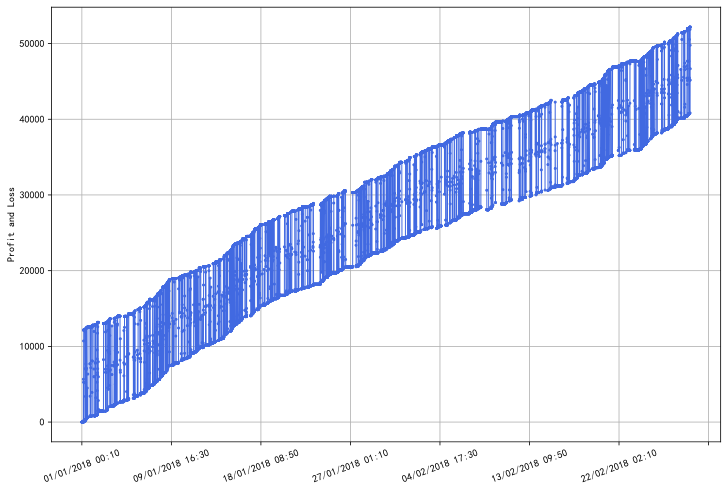

In [154]:
# All Pairs's PnL

for pair in stock_pairs_final[:1]:
    stock1 = pair[0]
    stock2 = pair[1]
    
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'].plot(figsize=(12,8), color='RoyalBlue', marker='o',lw = 1,markersize = 2)
    # plt.title('Cumulative PnL of ' + stock1 + ' and ' + stock2)
    plt.ylabel('Profit and Loss')
    plt.xlabel("")
    plt.grid()
    plt.xticks(rotation=20)
    # plt.savefig("./imgs/pnl_%s_%s.png"%(stock1, stock2), dpi=500)
    plt.show()


In [106]:
pnl_dataframe_strategy_1['Cum PnL']

Timestamp
01/01/2018 00:10         0.00
01/01/2018 00:15         0.00
01/01/2018 00:20         0.00
01/01/2018 00:25         0.00
01/01/2018 00:30         0.00
                      ...    
28/02/2018 23:35    124462.35
28/02/2018 23:40    133409.50
28/02/2018 23:45    135825.55
28/02/2018 23:50    135825.55
28/02/2018 23:55    135847.50
Name: Cum PnL, Length: 16990, dtype: float64

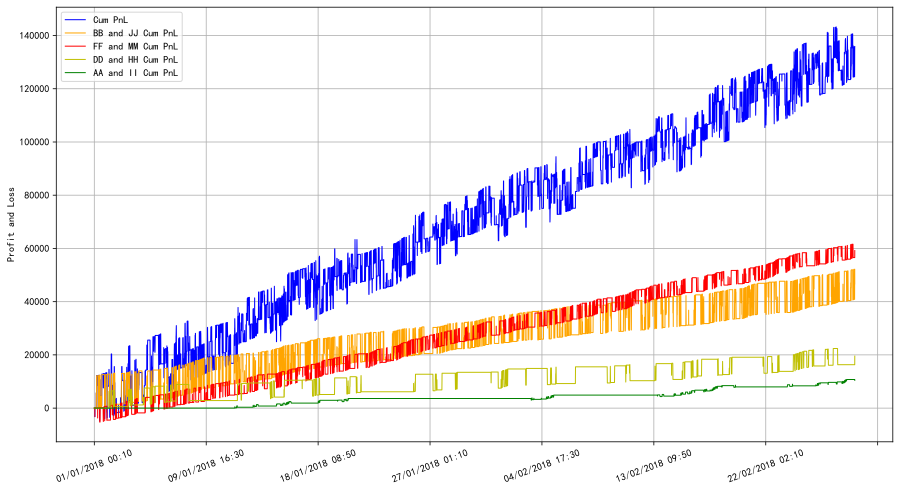

In [110]:
# All Pairs's PnLs (including total) in one graph

color_ = ['orange','r','y','g','b']
pnl_dataframe_strategy_1['Cum PnL'].plot(color='b',lw = 1)

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'].plot(figsize=(15,8), color=color_[stock_pairs_final.index(pair)%len(color_)],lw = 1)
    plt.legend(['Cum PnL', 'BB and JJ Cum PnL', 'FF and MM Cum PnL', 'DD and HH Cum PnL','AA and II Cum PnL'])
    # plt.title('Cumulative PnLs of the Trading Strategy')
    plt.ylabel('Profit and Loss')
    plt.xlabel("")
    plt.grid()
    plt.savefig("./imgs/all_pnl.png", dpi=500)
    plt.xticks(rotation=20)

In [108]:
# Send to CSV
pnl_dataframe_strategy_1.to_csv('./res/pnl_results.csv')